In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [231]:
#create linear regression model

#IMPORTANT NOTICE!
'''
########################################
This is taken from Homework 2 assignment
########################################
'''
def sums(x, y):
    '''
    This function creates all the necessary sums for the linear regression equations
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        sum_x (float) sum of all the x values
        sum_y (float) sum of all the y values
        sum_x2 (float) sum of all the squared x values
        sum_xy (float) sum of all the x values multiplied by their respective y values
    '''
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)
    return sum_x, sum_y, sum_x2, sum_xy

In [232]:
#Also from Homework 2
def B_i(x,y):
    '''
    This function calculates the slope (B_1) and intercept (B_0) of the regression
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        B1 (float) slope of the regression
        B0 (float) intercept for the regression
    '''
    sum_x, sum_y, sum_x2, sum_xy = sums(x,y)
    numerator = ((len(x) * sum_xy) - (sum_x * sum_y))
    denominator = ((len(x) * sum_x2) - (sum_x**2))
    B1 = numerator/denominator
    B0 = (sum_y - (B1 * sum_x)) / len(x)
    return B1, B0

In [233]:
#The ridge regression is based on the gradient descent from homework 4
#It works on matrices so that if you wanted more predictors it would be easy to expand it
def ridge_regression(x, y, Lr=0.1, penalty=0.1, epochs=10000):
    '''
    This function does a gradient descent for ridge regression.
    input:
        x: np array, predictor values
        y: np array, target values
        lr: float, learning rate
        lambda: float, ridge regularization strength
        epochs: int, number of iterations
    output:
        B: array with floats, Contains both the slopes and intercept after the gradient descent
    '''
    m, n = x.shape  #m = number of samples, n = number of features
    slope = []
    intercept = []
    #My B_i fxn is meant for only one predictor so if i want to expand it to a matrix it will need to change a bit
    for i in range(n):
        B1, B0 = B_i(x[:,i], y[i])  #Apply B_i for each row of x
        slope.append(B1)
        intercept.append(B0)
    B = np.zeros((n+1, 1))  #Initialize weights
    B[0] = intercept  #The first row is for intercepts
    B[1:] = np.array(slope).reshape(-1, 1)  #The rest are for slopes

    #need a column in X of ones to account for B having the intercept
    x_B = np.ones((m,n+1))
    x_B[:,1:] = x #now x_B has x as well as a column to account to intercepts

    for epoch in range(epochs):
        Y_pred = np.dot(x_B, B) #calculate predicted y vals
        err = Y_pred - y #find residuals

        B_pen = np.copy(B) #Creating a copy of B to not interfere with updating it
        B_pen[0] = 0 #set the intercept to 0
        
        dB = (1/m) * (np.dot(x_B.T, err) + penalty * B_pen) #calculate change
        B -= Lr * dB #apply changes to B

    return B

[https://www.kaggle.com/code/ninjaac/lasso-and-ridge-regression-from-scratch?utm_source=chatgpt.com]

Assisted in building the ridge regression model.. it is kind of hard to follow along with this because it uses a class.
I think I managed to apply my old functions into this method fairly well.

In [ ]:
#Now clean the data as in step 2
data = pd.read_csv('FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv')
data = data.drop(columns = ['Footnote'])
data = data[data['Measure Name'] == 'READM-30-AMI-HRRP']
#I forgot to only include heart attack patients in the first upload so I'll have to recomment everything which may be inconsistent with previous versions
data = data.dropna()
data['Number of Readmissions'] = data['Number of Readmissions'].astype(float)
print(data.head())
print(data.columns)

                      Facility Name  Facility ID State       Measure Name  \
0   SOUTHEAST HEALTH MEDICAL CENTER        10001    AL  READM-30-AMI-HRRP   
14     NORTH ALABAMA MEDICAL CENTER        10006    AL  READM-30-AMI-HRRP   
31               ST. VINCENT'S EAST        10011    AL  READM-30-AMI-HRRP   
47    SHELBY BAPTIST MEDICAL CENTER        10016    AL  READM-30-AMI-HRRP   
77     BAPTIST MEDICAL CENTER SOUTH        10023    AL  READM-30-AMI-HRRP   

    Number of Discharges  Excess Readmission Ratio  \
0                  296.0                    0.9483   
14                 315.0                    0.9704   
31                 148.0                    0.9675   
47                  77.0                    1.0186   
77                 194.0                    1.0485   

    Predicted Readmission Rate  Expected Readmission Rate  \
0                      13.0146                    13.7235   
14                     11.8750                    12.2373   
31                     11.854

In [235]:
#Make new column and pull out data to be used
data['Read_Dis_ratio'] = data['Number of Readmissions'] / data['Number of Discharges']
X_both = data['Read_Dis_ratio']
X = data['Number of Discharges']
Y = data['Excess Readmission Ratio']

In [236]:
#Having trouble with the regression working forgot to normalize data
mean_X = np.mean(X)
std_dev_X = np.std(X)
normal_X = (X-mean_X)/std_dev_X

In [237]:
normal_X = np.array(normal_X).reshape(-1,1)
Y = np.array(Y).reshape(-1,1)
print(normal_X.shape, Y.shape)
print(normal_X)


(1244, 1) (1244, 1)
[[ 0.46130755]
 [ 0.58904711]
 [-0.53371636]
 ...
 [-0.4059768 ]
 [-0.95727383]
 [-0.61439397]]


In [238]:
#Testing to see how different param effect the output
B = ridge_regression(normal_X,Y,epochs=300)
print(B)
B = ridge_regression(normal_X,Y,epochs=1000)
print(B)

[[ 1.0115168 ]
 [-0.01707499]]
[[ 1.0115168 ]
 [-0.01707499]]


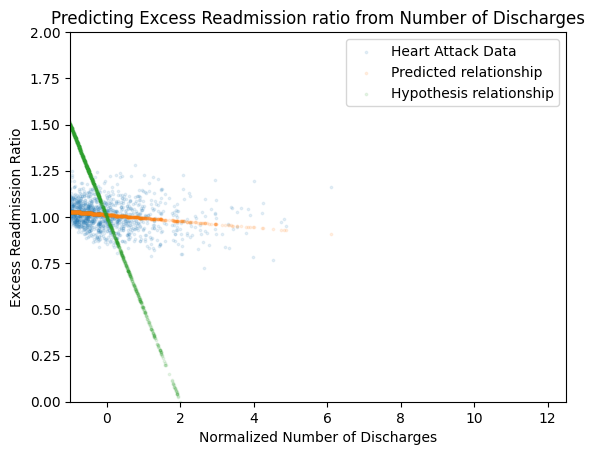

In [239]:
Y_pred = B[0] + B[1]*normal_X
Y_hypo = 1. - 0.5*normal_X
plt.scatter(normal_X, Y, s=3, alpha=0.1, label='Heart Attack Data')
plt.scatter(normal_X, Y_pred, s=3, alpha=0.1, label='Predicted relationship')
plt.scatter(normal_X, Y_hypo, s=3, alpha=0.1, label='Hypothesis relationship')
plt.ylim(0,2)
plt.xlim(-1,12.5)
plt.ylabel('Excess Readmission Ratio')
plt.xlabel('Normalized Number of Discharges')
plt.title('Predicting Excess Readmission ratio from Number of Discharges')
plt.legend()
plt.show()

It looks like the models results are not as extreme as my hypothesis but it still gives credit to the hypothesis by having a negative slope. Out of curiosity (one of the other questions I wanted to look at was how the ratio of readmissions to discharges relates to excess readmission ratio. I can do this easily with the model already built)

In [240]:
mean_X_both = np.mean(X_both)
std_dev_X_both = np.std(X_both)
normal_X_both = (X_both-mean_X_both)/std_dev_X_both
normal_X_both = np.array(normal_X_both).reshape(-1,1)
B = ridge_regression(normal_X_both,Y)

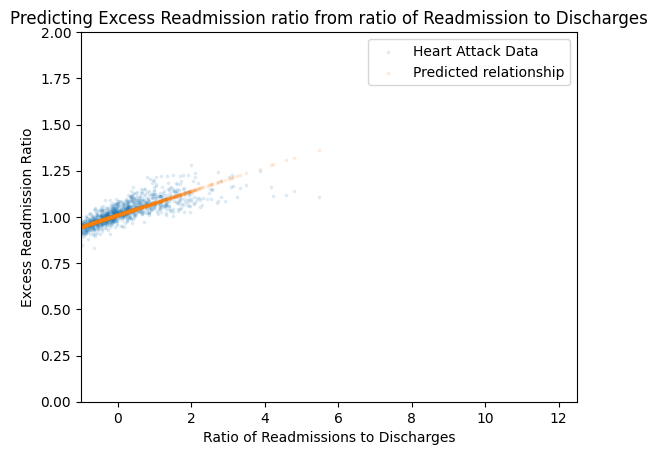

In [241]:
Y_pred_both = B[0] + B[1]*normal_X_both
plt.scatter(normal_X_both, Y, s=3, alpha=0.1, label='Heart Attack Data')
plt.scatter(normal_X_both, Y_pred_both, s=3, alpha=0.1, label='Predicted relationship')
plt.ylim(0,2)
plt.xlim(-1,12.5)
plt.ylabel('Excess Readmission Ratio')
plt.xlabel('Ratio of Readmissions to Discharges')
plt.title('Predicting Excess Readmission ratio from ratio of Readmission to Discharges')
plt.legend()
plt.show()

This relationship makes total sense.. It wouldn't make sense to really consider this as a question. Both are measures of how often people are readmitted.